# Template for Spectral and temporal modifications Lab


*From R. Badeau and G. Richard (with help from P. Vernhet), MAJ:2019*

**python version : 3.6**

In [1]:
import os, sys, wave, struct

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal
import IPython

from copy import deepcopy
from math import ceil
from scipy.io.wavfile import write

## Functions

In [2]:
def load_sound(file):
    return wave.open(file, 'rb')
    
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()

def nextpow2(x):
    assert x>0
    p = ceil(np.log2(x))
    x_ = 2**p
    assert 2**(p-1) < x <= x_
    return p, x_

def period(x, Fs, Pmin=1/300, Pmax=1/80, seuil=0.7) :
    # [P,voiced] = period(x,Fs,Pmin,Pmax,seuil);
    # If voiced = 1, P is the period signal x expressed in number of samples
    # If voiced = 0, P is equal to 10ms.Fs

    x = x - np.mean(x)
    N = len(x)

    Nmin = np.ceil(Pmin*Fs).astype(int)
    Nmax = 1 + np.floor(Pmax*Fs).astype(int)
    Nmax = np.min([Nmax,N])

    _,Nfft = nextpow2(2*N-1)
    X = np.fft.fft(x, n=Nfft)
    S = X * np.conj(X) / N
    r = np.real(np.fft.ifft(S))

    rmax = np.max(r[Nmin:Nmax])
    I = np.argmax(r[Nmin:Nmax])
    P = I+Nmin
    corr = (rmax/r[0]) * (N/(N-P))
    voiced = corr > seuil
    if not(voiced):
        P = np.round(10e-3*Fs)

    return P,voiced

## Reading and playing .wav file

Choose the name of sound for the rest of the notebook. Sounds are assumed to be set in a folder named 'sons_mutltipitch' (same directory as notebook).

In [3]:
data_path = os.getcwd()
filename = 'aeiou.wav'
sound = os.path.join(data_path, filename) 

### **Using wave**

In [4]:
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=11025, nframes=59964, comptype='NONE', compname='not compressed')


In [5]:
IPython.display.Audio('aeiou.wav')

In [10]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)

In [11]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

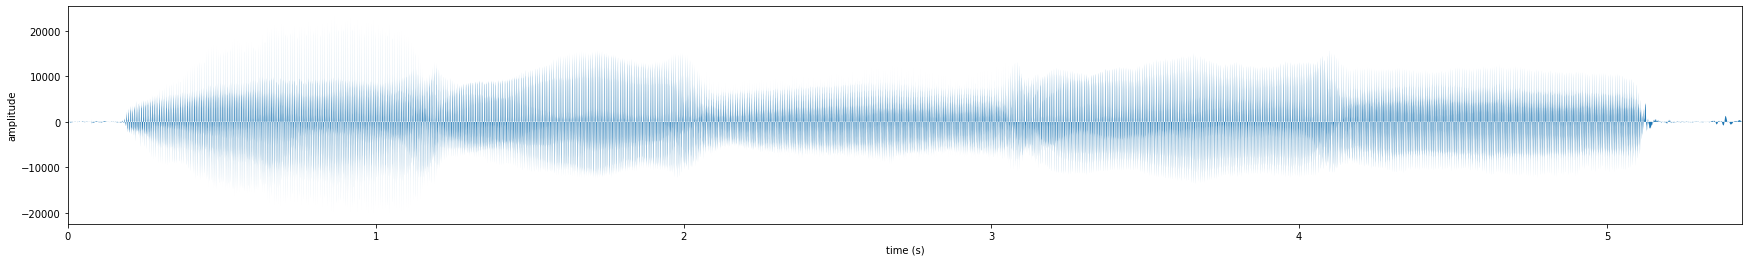

In [12]:
plot_sound(x, times)

In [13]:
write('new_aeiou.wav', Fs, np.array(x, dtype=np.int16)) # to write a new wave file

In [14]:
def AnalysisPitchMarks(s, Fs):
    Pa = Fs * 1e-2
    t_a = 0
    A = np.empty((1,3))
    while int(t_a + 2.5 * Pa) < s.size :
        # section starting @ t_a(n-1), ending @ t_a(n-1) + Pa(n-1)
        section = s[t_a: int(t_a + 2.5 * Pa)] 
        Pa, voiced = period(section, Fs) # Pa(n) and voiced(n)
        t_a += int(Pa) # t_a(n)
        A = np.vstack((A,[t_a, voiced, Pa]))
    A = A.T
    return A[:,1:] # get rid of first, uninitialized column

In [15]:
AnalysisPitchMarks(x, Fs)

array([[  110.,   220.,   330., ..., 59470., 59580., 59690.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       [  110.,   110.,   110., ...,   110.,   110.,   110.]])

In [16]:
def SynthesisMarks(x, Fs):
    A = AnalysisPitchMarks(x, Fs)
    _, n = A.shape
    B = np.zeros((2, n))
    B[0] = A[0]
    B[1] = np.arange(n)
    return B

In [17]:
SynthesisMarks(x, Fs).shape

(2, 705)

In [18]:
def Synthesis(s, Fs, A, B):
    k, k_end = 1, 1
    while (k_end < B.shape[1]-1) and (B[1, k_end] < A.shape[1]-1):
        k_end += 1
    y = np.zeros(int(B[0, k_end] + A[2, int(B[1,k_end])]))
    for k in range(k_end):
        n_k = int(B[1,k])
        t_a, t_s, Pa = A[0, n_k], B[0, k], A[2, n_k]
        section = s[int(t_a - Pa): int(t_a + Pa)+1]
        w = section * scipy.signal.windows.hann(int(2 * Pa + 1))
        y[int(t_s - Pa) : int(t_s + Pa) +1] += w
    return y

In [19]:
A = AnalysisPitchMarks(x, Fs)
B = SynthesisMarks(x, Fs)

In [20]:
synth = Synthesis(x, Fs, A, B)

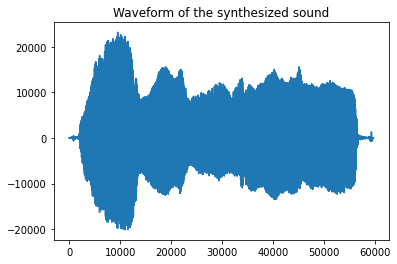

In [21]:
plt.title('Waveform of the synthesized sound')
plt.plot(synth)
plt.show()

In [23]:
IPython.display.Audio(synth, rate=Fs)

The sound is correctly reconstructed, without any visible modification.

In [24]:
def ChangeTimeScale(alpha, A, Fs):
    ts,  n_k = 1, 1
    B = np.empty((1,2)) # init B with a column that we wil drop
    while n_k + 1/alpha < A.shape[1] - 1:
        n_k += 1/alpha
        ts += A[2, int(n_k)] # Pa(int(n_k))
        B = np.vstack((B,[ts, int(n_k)]))
    B = B.T
    return B[:, 1:]

In [27]:
B = ChangeTimeScale(0.3, A, Fs)
synth_new_time = Synthesis(x, Fs, A, B)
synth_new_time.shape

(17829,)

In [29]:
IPython.display.Audio(synth_new_time, rate=Fs)

The time scale is correctly speeded up, while the pitch remains the same.

In [30]:
def ChangePitchScale(beta, A, Fs):
    ts,  n_k = 1, 1
    if A[1, n_k]:
        scale = 1/beta
    else:
        scale = 1
    B = np.empty((1,2)) # init B with a column that we wil drop
    while max(int(n_k) + 1, int(n_k) + 1/scale) < A.shape[1] - 1 :
        n_k += scale 
        if A[1, int(n_k)]:
            scale = 1/beta
        else:
            scale = 1
        ts += scale * A[2, int(n_k)]
        B = np.vstack((B, [int(ts), int(n_k)]))
    B = B.T
    return B[:, 1:]

In [31]:
B = ChangePitchScale(2, A, Fs)

In [32]:
synth_new_pitch = Synthesis(x, Fs, A, B)
synth_new_pitch.shape

(59471,)

In [34]:
IPython.display.Audio(synth_new_pitch, rate=Fs)

The pitch sounds higher, while the duration of the sound remains the initial one, which was our goal.

In [35]:
def ChangeBothScales(alpha, beta, A, Fs):
    ts,  n_k = 1, 1
    if A[1, n_k]:
        scale = 1/beta
    else:
        scale = 1
    B = np.empty((1,2)) # init B with a column that we wil drop
    while max(int(n_k) + 1 + 1/alpha, int(n_k) + 1/scale + 1/alpha) < A.shape[1] :
        n_k += scale * 1/alpha
        if A[1, int(n_k)]:
            scale = 1/beta
        else:
            scale = 1
        ts += scale * A[2, int(n_k)]
        B = np.vstack((B, [int(ts), int(n_k)]))
    B = B.T
    return B[:, 1:]

In [36]:
B = ChangeBothScales(0.5, 4, A, Fs)

In [37]:
synth_new = Synthesis(x, Fs, A, B)
synth_new.shape

(29825,)

In [38]:
IPython.display.Audio(synth_new, rate=Fs)

This function works correctly : we can hear the change in pitch or time scale when playing with alpha and beta. Besides that, when we set one of alpha or beta to one, the sound is the same as the one synthesized when only using ChangePitchScale or ChangeTimeScale. I checked that it had the same length (number of samples to be more accurate than seconds) and sounded as supposed.